In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import read_stats, assign_channels, plot_kde
import scipy
from itertools import combinations, product
from tqdm import tqdm
import scipy.stats
import pickle
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi']=500
rng = np.random.default_rng()

# Define samples and channels

In [2]:
channels={1:'Nur77_GFP',2:'Foxp3',3:'MHCII',4:'CD4',5:'TCF1',6:'CellTracker Deep Red',7:'CD8a',8:'1-5'}
conditions={'1L':'Alum+LPS+KLH','1R':'Alum+LPS','2L':'Alum+KLH','2R':'Alum','3L':'Alum+LPS','3R':'Alum'}
opposing_side_conditions={}
for condition in conditions:
    if condition[1]=='L':
        opposing_side_conditions[condition]=conditions[condition[0]+'R']
    if condition[1]=='R':
        opposing_side_conditions[condition]=conditions[condition[0]+'L']

In [3]:
samples=['1L','1R','2L','2R','3L','3R']
cell_types=['Tconv','Treg','mig']

# Import Segmentation Data

In [4]:
imported=True

if not imported:
    cells={}
    for sample in samples: #import segmented Tconv Treg and migratory cell data
        temp_gb=assign_channels(read_stats(r'..\\240424_nur77_thick_again\\'+sample+'_Statistics'),channels).groupby('Surpass Object')
        for name,group in temp_gb:
            cells[sample+'_'+name.split('_')[0]]=group

    with open('cell_data.pickle','wb') as f:
        pickle.dump(cells,f)

In [5]:
with open('cell_data.pickle','rb') as f:
    cells=pickle.load(f)

# Bulk Analysis

In [9]:
for sample in samples:
    temp_df=cells[sample+'_Tconv'] #filter Tconv for CD4 T cells
    cells[sample+'_Th']=temp_df[temp_df['Intensity_Sum_CD4']>50]

Text(0.5, 1.0, 'Tregs')

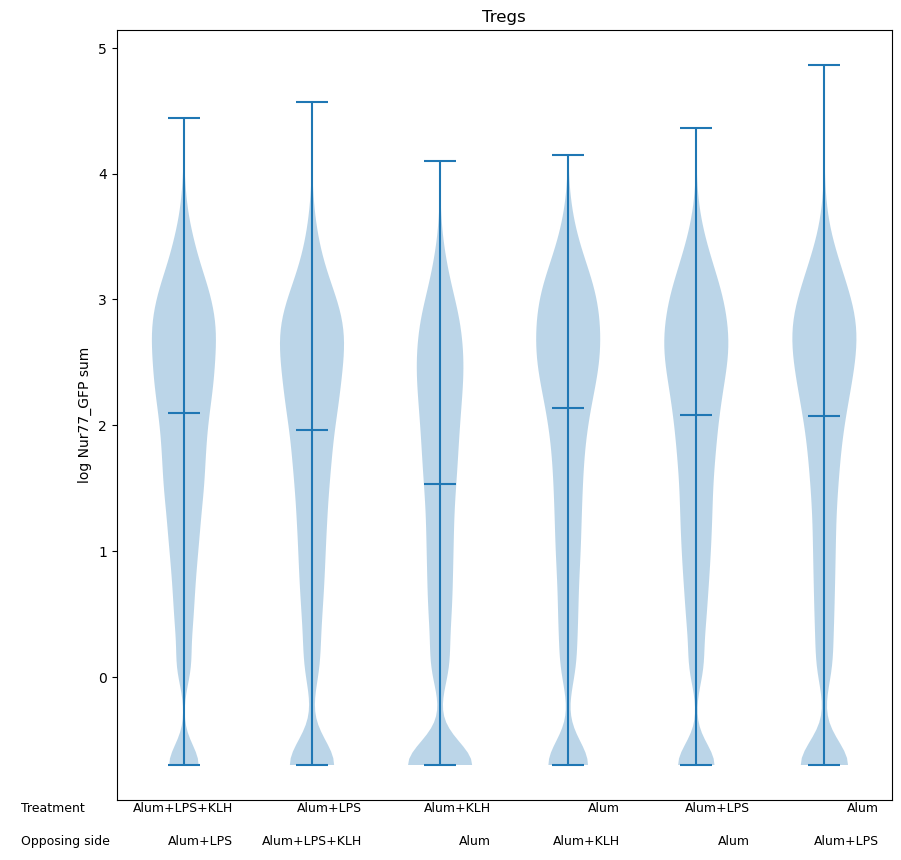

In [6]:
plot_data=[]
for sample in samples:
    temp_df=cells[sample+'_Treg']
    plot_data.append(temp_df['Intensity_Sum_Nur77_GFP'])
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series+0.2) for series in plot_data],showmedians=True)
plt.ylabel('log Nur77_GFP sum')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
                      rowLabels=['Treatment','','Opposing side'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Tregs')

Text(0.5, 1.0, 'Tregs')

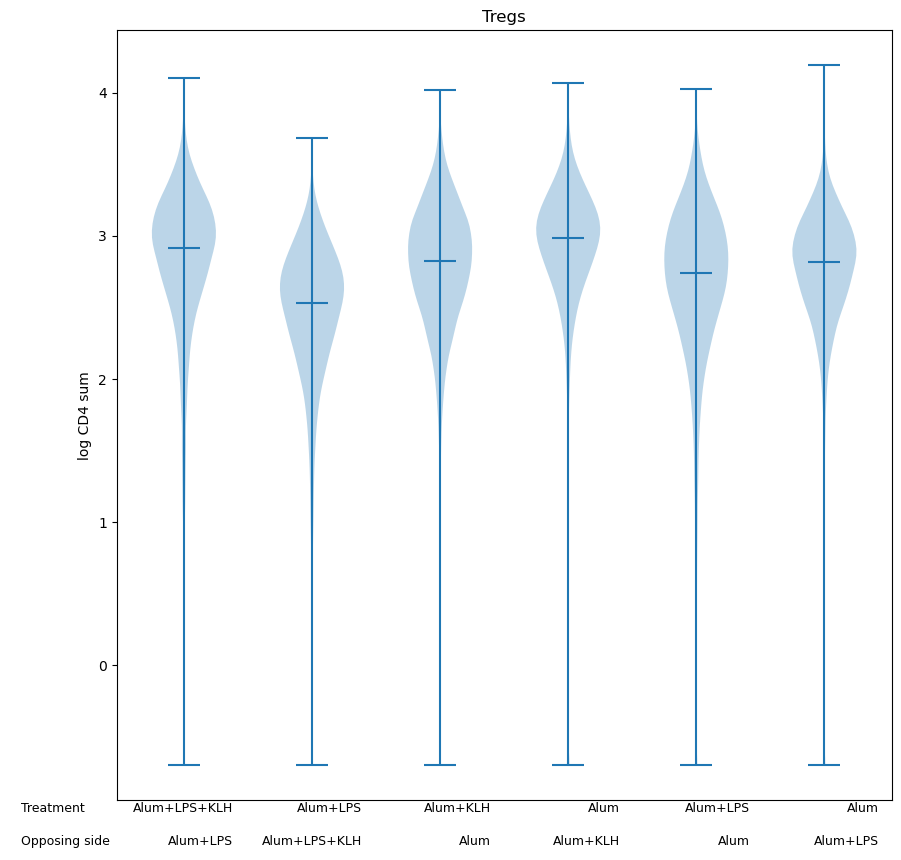

In [7]:
plot_data=[]
for sample in samples:
    temp_df=cells[sample+'_Treg']
    plot_data.append(temp_df['Intensity_Sum_CD4'])
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series+0.2) for series in plot_data],showmedians=True)
plt.ylabel('log CD4 sum')
# plt.xticks([1,2,3,4],[conditions[sample] for sample in samples])'
plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
                      rowLabels=['Treatment','','Opposing side'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Tregs')

Text(0.5, 1.0, 'CD4 Tconv')

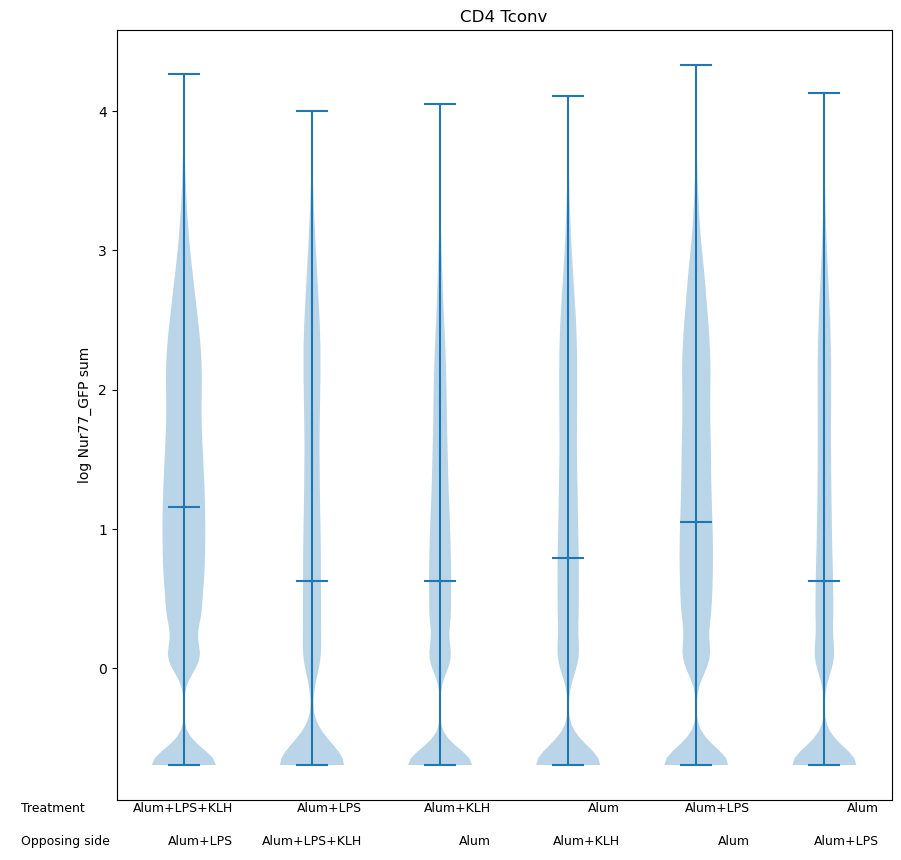

In [10]:
plot_data=[]
for sample in samples:
    temp_df=cells[sample+'_Th']
    plot_data.append(temp_df['Intensity_Sum_Nur77_GFP'])
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series+0.2) for series in plot_data],showmedians=True)
plt.ylabel('log Nur77_GFP sum')
plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
                      rowLabels=['Treatment','','Opposing side'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('CD4 Tconv')

Text(0.5, 1.0, 'CD4 Tconv')

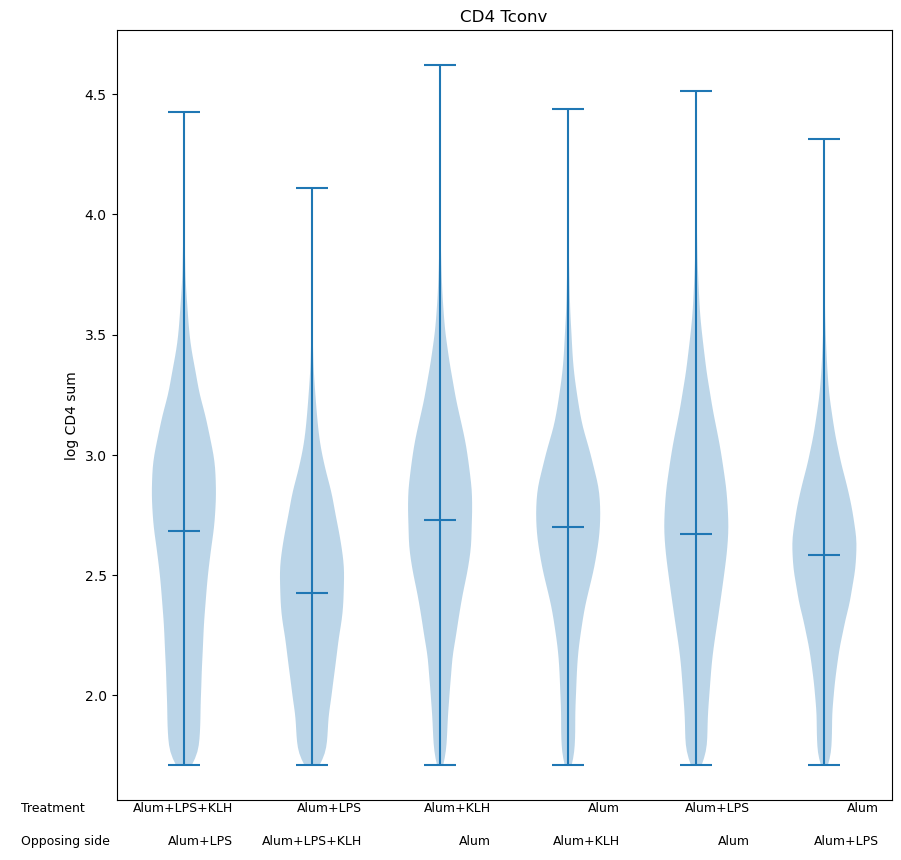

In [ ]:
plot_data=[]
for sample in samples:
    temp_df=cells[sample+'_Th']
    plot_data.append(temp_df['Intensity_Sum_CD4'])
    # plot_data.append(temp_df[temp_df['Intensity_Sum_Nur77_GFP']>0]['Intensity_Sum_Nur77_GFP'])

plt.violinplot([np.log10(series+0.2) for series in plot_data],showmedians=True)
plt.ylabel('log CD4 sum')
plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
                      rowLabels=['Treatment','','Opposing side'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('CD4 Tconv')

# Spatial Statistics

In [12]:
cells.keys()

dict_keys(['1L_Tconv', '1L_Treg', '1L_mig', '1R_Tconv', '1R_Treg', '1R_mig', '2L_Tconv', '2L_Treg', '2L_mig', '2R_Tconv', '2R_Treg', '2R_mig', '3L_Tconv', '3L_Treg', '3L_mig', '3R_Tconv', '3R_Treg', '3R_mig', '1L_Th', '1R_Th', '2L_Th', '2R_Th', '3L_Th', '3R_Th'])

In [13]:
d_max=20
nur77_thresh=50
n_bins_GFP=10
_,log_GFP_bins=np.histogram(np.concatenate([np.log10(cells[f'{sample}_Th']['Intensity_Sum_Nur77_GFP']+0.5) for sample in samples]),bins=n_bins_GFP)

In [14]:
cell_pairs={}
pair_types=[('Th','mig'),('Treg','mig'),('mig','mig')]
for sample in samples:
    for pair_type in pair_types:
        cell_pairs['_'.join([sample,*pair_type])]=scipy.spatial.distance.cdist(np.array([cells['_'.join([sample,pair_type[0]])]['Position_{}'.format(dir)] for dir in ['X','Y','Z']]).T,
                                                                               np.array([cells['_'.join([sample,pair_type[1]])]['Position_{}'.format(dir)] for dir in ['X','Y','Z']]).T)
        cells['_'.join([sample,pair_type[0]])].insert(1,f'Distance_{pair_type[1]}',np.min(cell_pairs['_'.join([sample,*pair_type])],axis=1))
        # cells['_'.join([sample,pair_type[0]])][f'Distance_{pair_type[1]}']=np.zeros(len(cells['_'.join([sample,pair_type[0]])]))
    cells[f'{sample}_mig']['proximal_Treg_count']=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mig']<d_max),axis=0)
    cells[f'{sample}_mig']['proximal_Th_count']=np.sum(np.int8(cell_pairs[f'{sample}_Th_mig']<d_max),axis=0)
    cells[f'{sample}_mig']['proximal_GFP_hi_Th_count']=np.sum(np.int8(cell_pairs[f'{sample}_Th_mig'][np.array(cells[f'{sample}_Th']['Intensity_Sum_Nur77_GFP']>nur77_thresh),:]<d_max),axis=0)
    cells[f'{sample}_mig']['proximal_GFP_hi_Treg_count']=np.sum(np.int8(cell_pairs[f'{sample}_Treg_mig'][np.array(cells[f'{sample}_Treg']['Intensity_Sum_Nur77_GFP']>nur77_thresh),:]<d_max),axis=0)
    Th_proximity_mask=cell_pairs[f'{sample}_Th_mig']<d_max
    Th_nur77_arr=np.log10(cells[f'{sample}_Th']['Intensity_Sum_Nur77_GFP']+0.5)
    mig_proximal_Th_GFP=[Th_nur77_arr[Th_proximity_mask[:,i]] for i in range(Th_proximity_mask.shape[1])]
    mig_proximal_Th_GFP_hist=np.array([np.histogram(GFP_dist,bins=log_GFP_bins)[0] for GFP_dist in mig_proximal_Th_GFP])
    cells[f'{sample}_mig']['proximal_Th_GFP_hist']=[list(mig_proximal_Th_GFP_hist[i]) for i in range(mig_proximal_Th_GFP_hist.shape[0])]
    cells[f'{sample}_mig']['proximal_Th_GFP_mean']=[np.mean(mig_proximal_Th_GFP[i]) for i in range(Th_proximity_mask.shape[1])]

In [15]:
n_bins_n_proximal_GFPhi_Th=10
_,n_proximal_GFPhi_Th_bins=np.histogram(np.concatenate([cells[f'{sample}_mig']['proximal_GFP_hi_Th_count'] for sample in samples]),bins=n_bins_n_proximal_GFPhi_Th)
n_proximal_GFPhi_Th_bin_width=n_proximal_GFPhi_Th_bins[1]-n_proximal_GFPhi_Th_bins[0]
n_bins_n_proximal_Tr=10
_,n_proximal_Tr_bins=np.histogram(np.concatenate([cells[f'{sample}_mig']['proximal_Treg_count'] for sample in samples]),bins=n_bins_n_proximal_Tr)
n_proximal_Tr_bin_width=n_proximal_Tr_bins[1]-n_proximal_Tr_bins[0]

In [16]:
proximity_GFP_dist={}
for sample in samples:
    container=np.zeros((n_bins_n_proximal_GFPhi_Th,n_bins_GFP))
    cells[f'{sample}_mig']['n_proximal_GFPhi_Th_bin']=np.minimum(np.int8(np.floor(cells[f'{sample}_mig']['proximal_GFP_hi_Th_count']/n_proximal_GFPhi_Th_bin_width)),9)
    for _,row in cells[f'{sample}_mig'].iterrows():
        container[row['n_proximal_GFPhi_Th_bin']]+=row['proximal_Th_GFP_hist']
    for i in range(n_bins_n_proximal_GFPhi_Th):
        if np.sum(container[i])>0:
            container[i]/=np.sum(container[i])
    proximity_GFP_dist[sample]=container

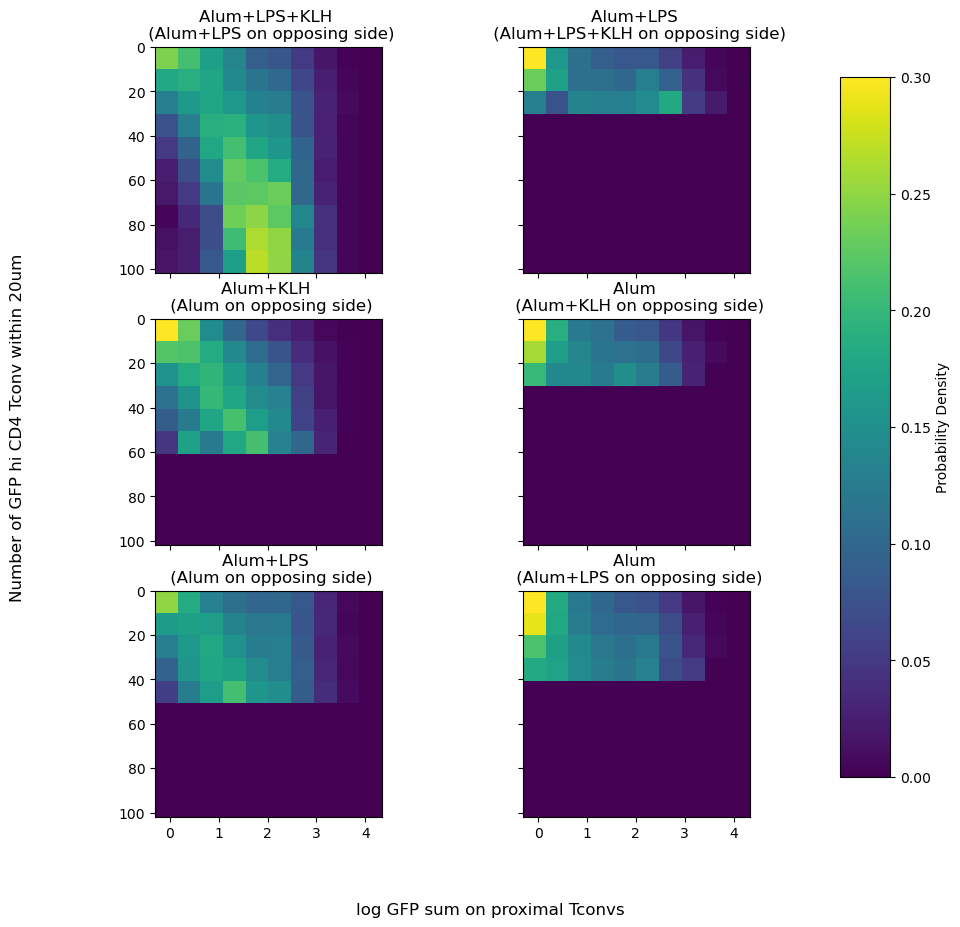

In [15]:
plot_grid=(3,2)
fig,axs=plt.subplots(*plot_grid,sharex=True,sharey=True)
n_bins_x,x_bins=n_bins_GFP,log_GFP_bins
n_bins_y,y_bins=n_bins_n_proximal_GFPhi_Th,n_proximal_GFPhi_Th_bins
ticks_loc=lambda x,n_bins,bins: n_bins/(bins[-1]-bins[0])*x-(0.5+n_bins*bins[0]/(bins[-1]-bins[0]))
y_ticks=np.arange(0,101,20)
x_ticks=np.arange(0,5,1)
for i,sample in enumerate(samples):
    ax=axs[np.unravel_index(i,plot_grid)]
    im=ax.imshow(proximity_GFP_dist[sample],vmin=0,vmax=0.3)
    ax.set_title(f'{conditions[sample]} \n ({opposing_side_conditions[sample]} on opposing side)')
    ax.set_xticks([ticks_loc(x,n_bins_x,x_bins) for x in x_ticks],labels=x_ticks)
    ax.set_yticks([ticks_loc(y,n_bins_y,y_bins) for y in y_ticks],labels=y_ticks)
fig.supxlabel('log GFP sum on proximal Tconvs')
fig.supylabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar=fig.colorbar(im,cax=cbar_ax)
cbar.set_label('Probability Density')

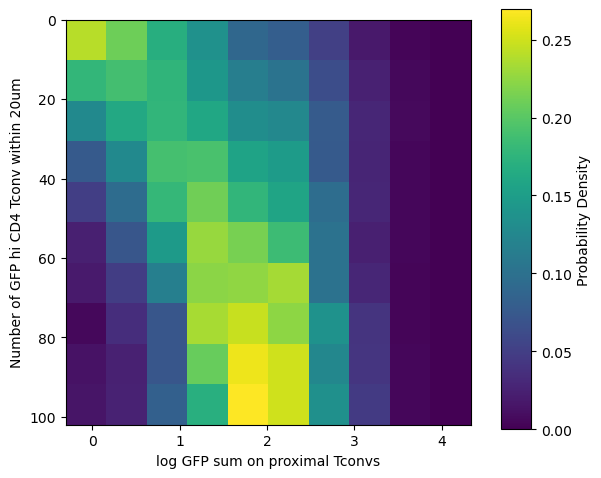

In [16]:
fig,ax=plt.subplots(figsize=(6,6))
n_bins_x,x_bins=n_bins_GFP,log_GFP_bins
n_bins_y,y_bins=n_bins_n_proximal_GFPhi_Th,n_proximal_GFPhi_Th_bins
ticks_loc=lambda x,n_bins,bins: n_bins/(bins[-1]-bins[0])*x-(0.5+n_bins*bins[0]/(bins[-1]-bins[0]))
y_ticks=np.arange(0,101,20)
x_ticks=np.arange(0,5,1)
i=0
sample='1L'
# im=ax.imshow(proximity_GFP_dist[sample],vmin=0,vmax=0.3)
im=ax.imshow(proximity_GFP_dist[sample])
# ax.set_title(f'{conditions[sample]} \n ({opposing_side_conditions[sample]} on opposing side)')
ax.set_xticks([ticks_loc(x,n_bins_x,x_bins) for x in x_ticks],labels=x_ticks)
ax.set_yticks([ticks_loc(y,n_bins_y,y_bins) for y in y_ticks],labels=y_ticks)
ax.set_xlabel('log GFP sum on proximal Tconvs')
ax.set_ylabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar=fig.colorbar(im,cax=cbar_ax)
cbar.set_label('Probability Density')

$f(\textrm{GFP on proximal \textbf{Tconvs}; number of proximal GFP+ Tconvs})$

C:\Users\Wong Lab\AppData\Local\Temp\ipykernel_30428\1469217085.py:10: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.figlegend([histogram,line],labels=['observed','null (n=100)'])


Text(0.02, 0.5, 'Probability Density')

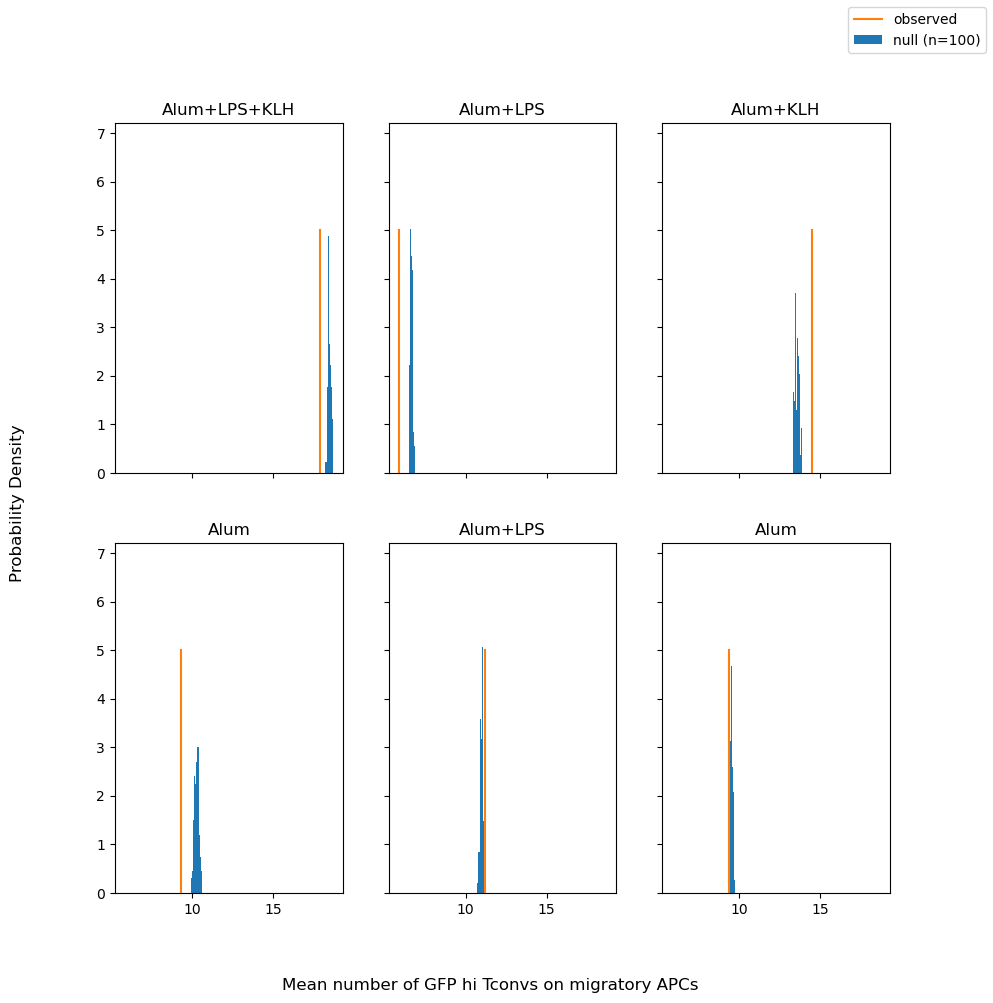

In [17]:
grid_size=(2,3)
fig,axs=plt.subplots(*grid_size,sharex=True,sharey=True)

for i,sample in enumerate(samples):
    prob_GFP_hi=np.sum(np.int8(cells[f'{sample}_Th']['Intensity_Sum_Nur77_GFP']>nur77_thresh))/len(cells[f'{sample}_Th'])
    histogram=axs[np.unravel_index(i,grid_size)].hist([np.mean([rng.binomial(cell['proximal_Th_count'],prob_GFP_hi) for _,cell in cells[f'{sample}_mig'].iterrows()]) for _ in range(100)],density=True)
    line=axs[np.unravel_index(i,grid_size)].plot(np.full(2,np.mean(cells[f'{sample}_mig']['proximal_GFP_hi_Th_count'])),[0,5])
    axs[np.unravel_index(i,grid_size)].set_title(conditions[sample])
# plt.violinplot([np.array([rng.binomial(cell['proximal_Th_count'],prob_GFP_hi) for _,cell in cells[f'{sample}_mig'].iterrows()]),cells[f'{sample}_mig']['proximal_GFP_hi_Th_count']],showmedians=True)
plt.figlegend([histogram,line],labels=['observed','null (n=100)'])
fig.supxlabel('Mean number of GFP hi Tconvs on migratory APCs')
fig.supylabel('Probability Density')

# Spatial Distributions

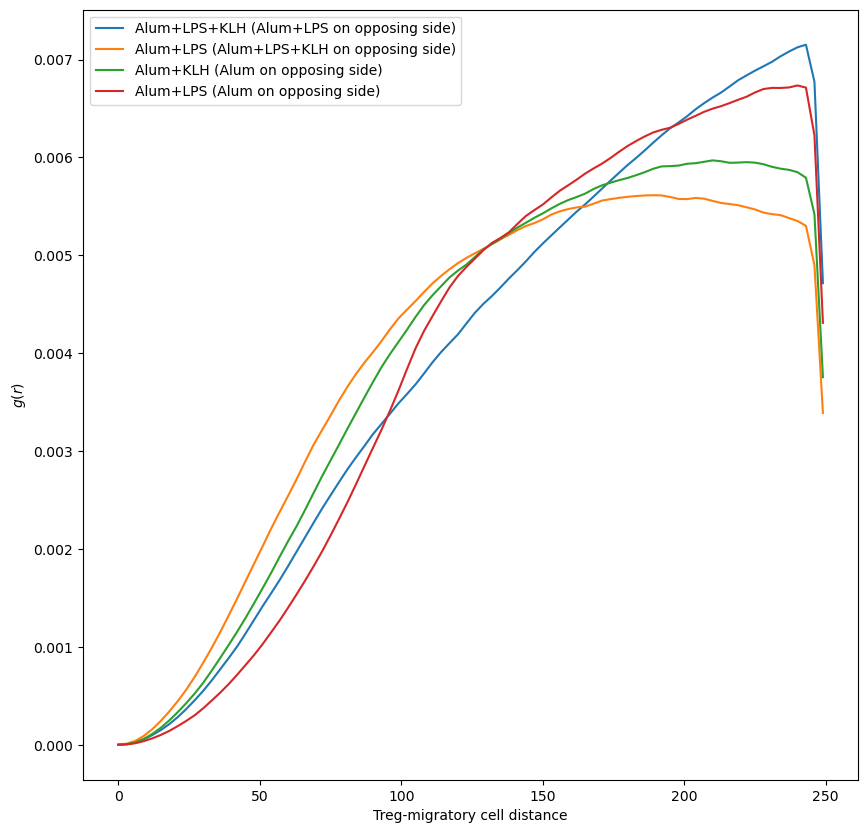

In [23]:
plot_data=[cell_pairs[sample+'_Treg_mig'].flatten() for sample in samples]
plot_data=[series[series<250] for series in plot_data]
kde_objs=[scipy.stats.gaussian_kde(series) for series in plot_data]
x_range=np.arange(0,50,3)
for i,sample in enumerate(samples):
    plt.plot(x_range,kde_objs[i](x_range),label=f'{conditions[sample]} ({opposing_side_conditions[sample]} on opposing side)')
plt.xlabel('Treg-migratory cell distance')
plt.ylabel('$g(r)$')
plt.legend()


In [ ]:
plot_data=[cell_pairs[sample+'_Treg_mig'].flatten() for sample in samples]
plot_data=[series[series<250] for series in plot_data]


In [11]:
plot_data

[array([870.59470752, 851.25992374, 857.83603719, ..., 754.73185563,
        665.44567051, 681.82569081]),
 array([415.26170084, 388.28097046, 374.10274825, ..., 229.30935712,
        236.366112  , 339.78297741]),
 array([385.52244029, 415.63856062, 404.23473603, ..., 160.81292045,
        172.2067303 , 198.72652979]),
 array([300.75094388, 302.10584919, 411.50034603, ..., 603.35071366,
        666.37638825, 663.58934114])]

In [38]:
normalize=lambda arr,i:arr/arr[i]

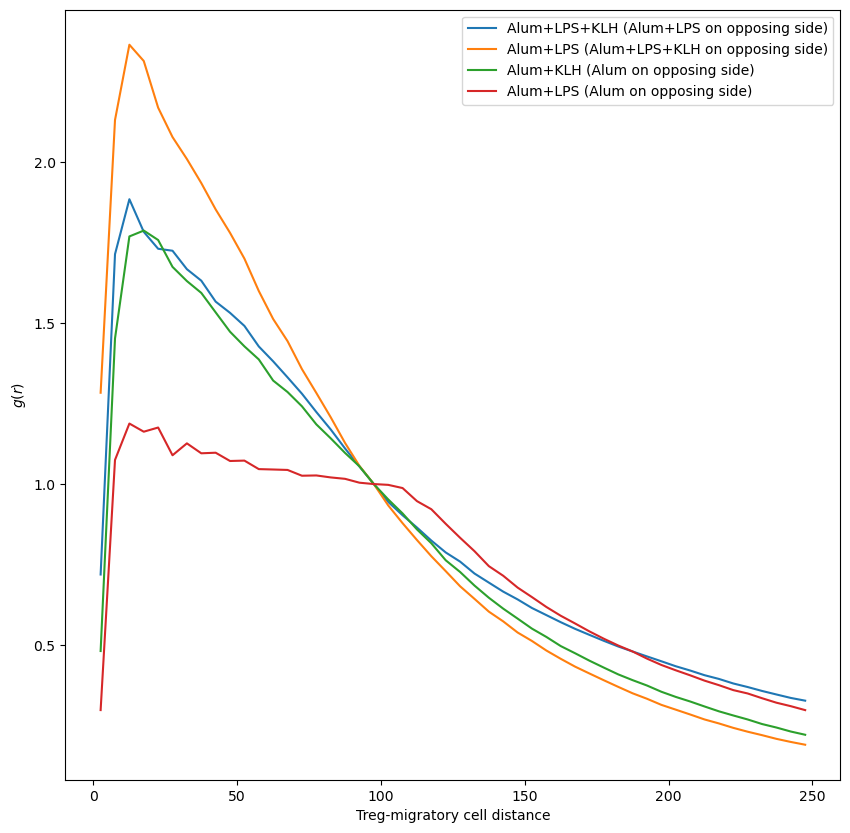

In [39]:
plot_data=[cell_pairs[sample+'_Treg_mig'].flatten() for sample in samples]
plot_data=[series[series<250] for series in plot_data]
hist=[np.histogram(series,bins=np.arange(0,251,5))[0] for series in plot_data]
bin_midpts=np.arange(2.5,250,5)
for i,sample in enumerate(samples):
    plt.plot(bin_midpts,normalize(hist[i]/bin_midpts**2,19),label=f'{conditions[sample]} ({opposing_side_conditions[sample]} on opposing side)')
plt.xlabel('Treg-migratory cell distance')
plt.ylabel('$g(r)$')
plt.legend()

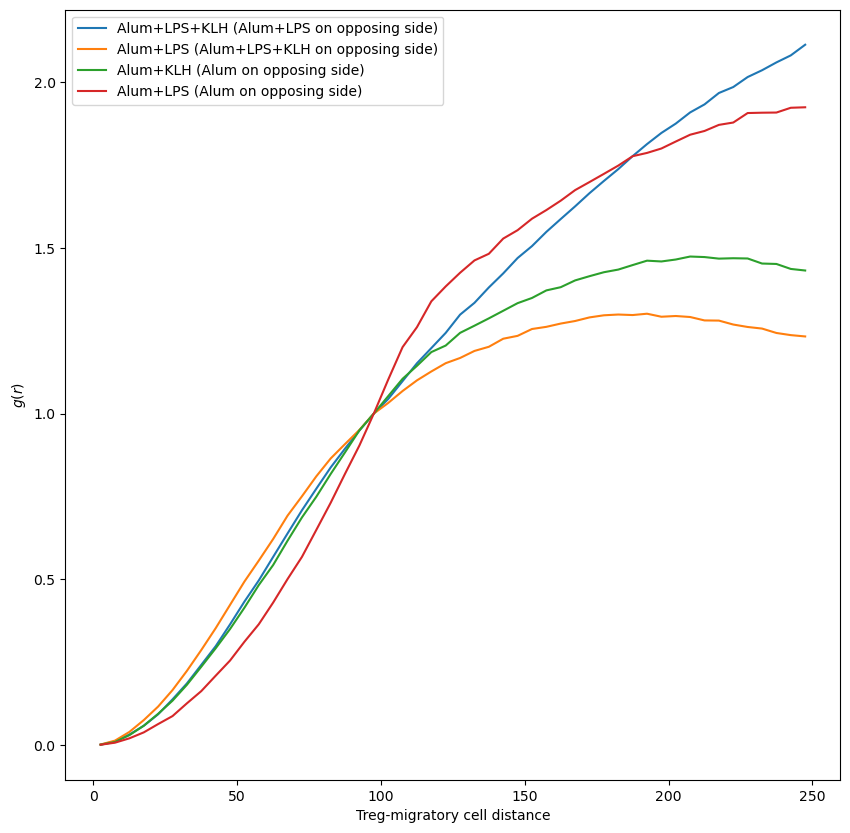

In [40]:
plot_data=[cell_pairs[sample+'_Treg_mig'].flatten() for sample in samples]
plot_data=[series[series<250] for series in plot_data]
hist=[np.histogram(series,bins=np.arange(0,251,5))[0] for series in plot_data]
bin_midpts=np.arange(2.5,250,5)
for i,sample in enumerate(samples):
    plt.plot(bin_midpts,normalize(hist[i],19),label=f'{conditions[sample]} ({opposing_side_conditions[sample]} on opposing side)')
plt.xlabel('Treg-migratory cell distance')
plt.ylabel('$g(r)$')
plt.legend()

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduc

Text(0.5, 1.0, 'CD4 Tconv')

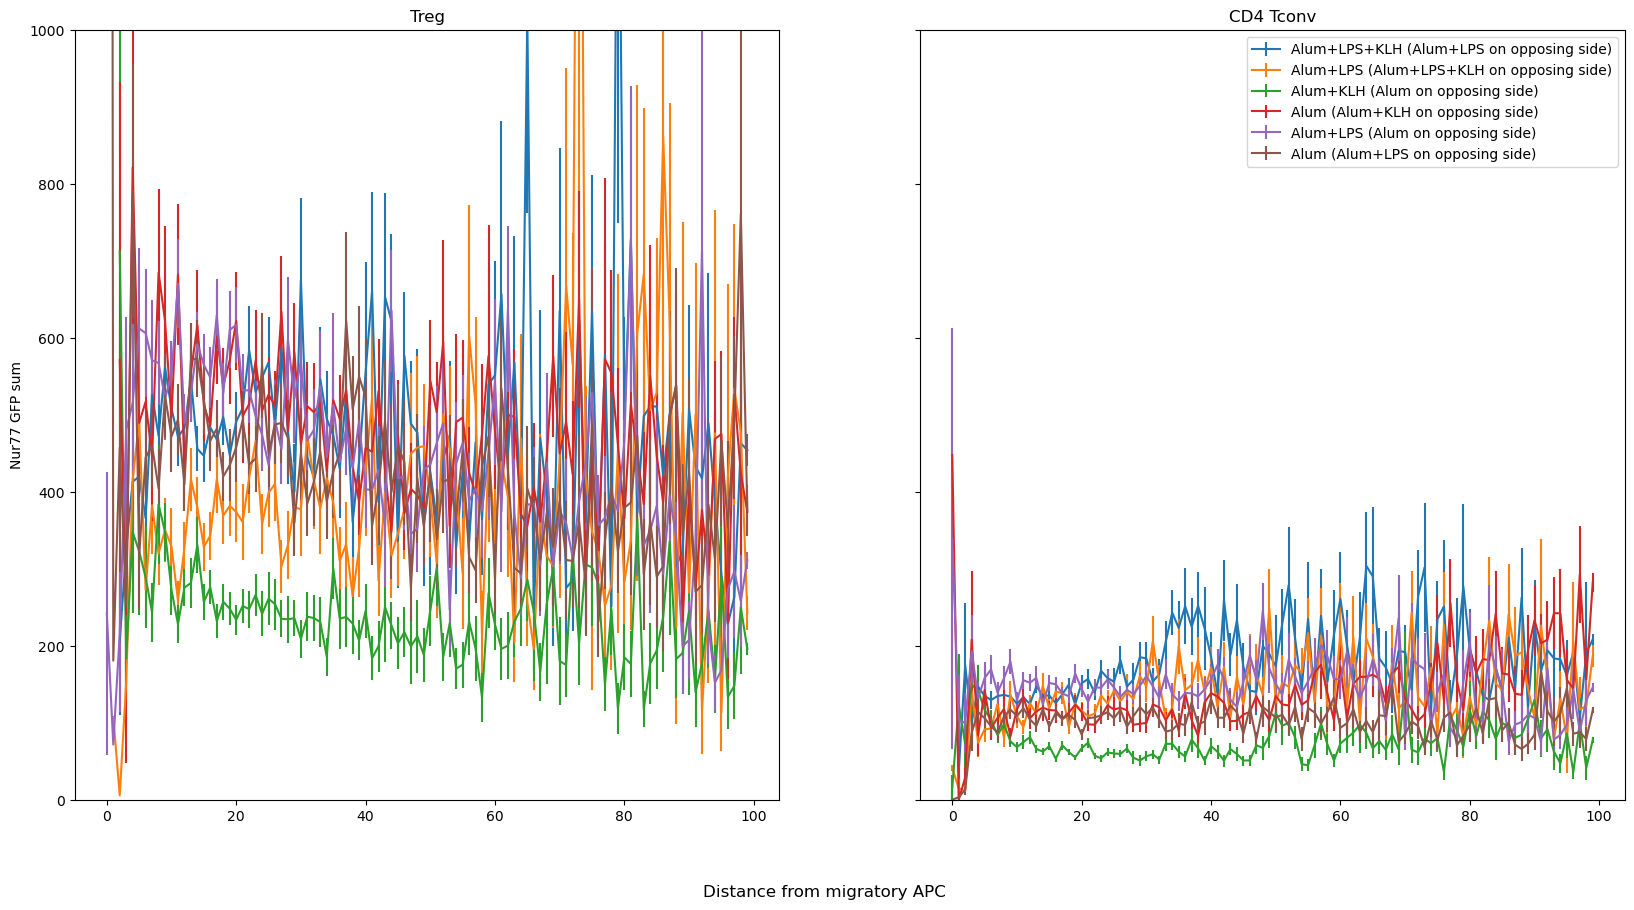

In [38]:
bin_width=1
n_bins=100
fig,axs=plt.subplots(1,2,sharex=True,sharey=True,figsize=(20,10))
for sample in samples:
    for i,cell_type in enumerate(['Treg','Th']):
        val_container=[[] for _ in range(n_bins)]
        for _,cell in cells[f'{sample}_{cell_type}'].iterrows():
            val_container[min(int(cell['Distance_mig']//bin_width),99)].append(cell['Intensity_Sum_Nur77_GFP'])
        mean_arr=[np.mean(bin_vals) for bin_vals in val_container]
        std_arr=[scipy.stats.sem(bin_vals) for bin_vals in val_container]
        axs[i].errorbar(np.arange(0,bin_width*n_bins,bin_width),mean_arr,yerr=std_arr,label=f'{conditions[sample]} ({opposing_side_conditions[sample]} on opposing side)')
fig.supxlabel('Distance from migratory APC')
axs[0].set_ylabel('Nur77 GFP sum')
axs[0].set_ylim(0,1000)
axs[1].legend()
axs[0].set_title('Treg')
axs[1].set_title('CD4 Tconv')

# Coarser Spatial Analysis

Text(0.5, 1.0, 'Migratory APCs')

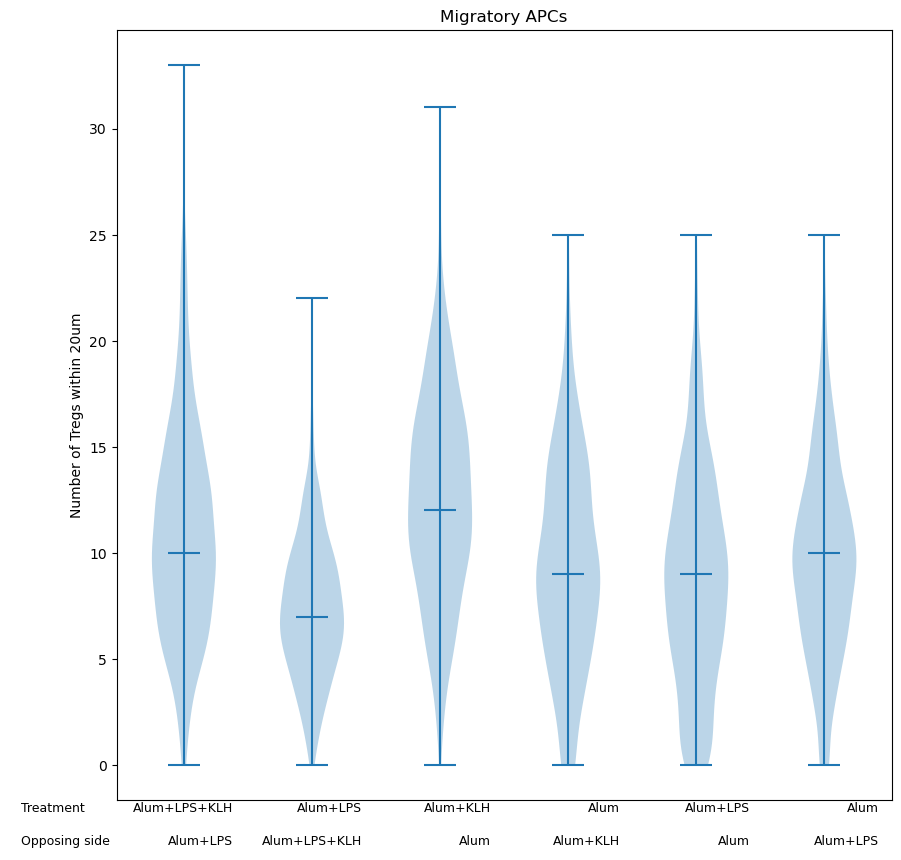

In [89]:
plot_data=[np.sum(np.int8(cell_pairs[f'{sample}_Treg_mig']<d_max),axis=0) for sample in samples]
plt.violinplot([cells[f'{sample}_mig']['proximal_Treg_count']],showmedians=True)
plt.ylabel(f'Number of Tregs within {d_max}um')
plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
                      rowLabels=['Treatment','','Opposing side'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Migratory APCs')

In [117]:
cell_pairs[f'{sample}_Th_mig'].shape

(80174, 1400)

In [128]:
# plot_data=[]
# for sample in samples:
#     mask=np.array(cells[f'{sample}_Th']['Intensity_Sum_Nur77_GFP']>nur77_thresh)
#     idx=np.array([i for i,truth in enumerate(mask) if truth],dtype=np.int32)
#     plot_data.append(np.sum(np.int8(cell_pairs[f'{sample}_Th_mig'][idx,:]<d_max),axis=0))
# plt.violinplot(plot_data,showmedians=True)
# plt.ylabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
# plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
#                       rowLabels=['Treatment','','Opposing side'],
#                       loc='bottom',
#                       edges='open')
# plt.xticks([])
# plt.title('Migratory APCs')

Text(0.5, 1.0, 'Migratory APCs')

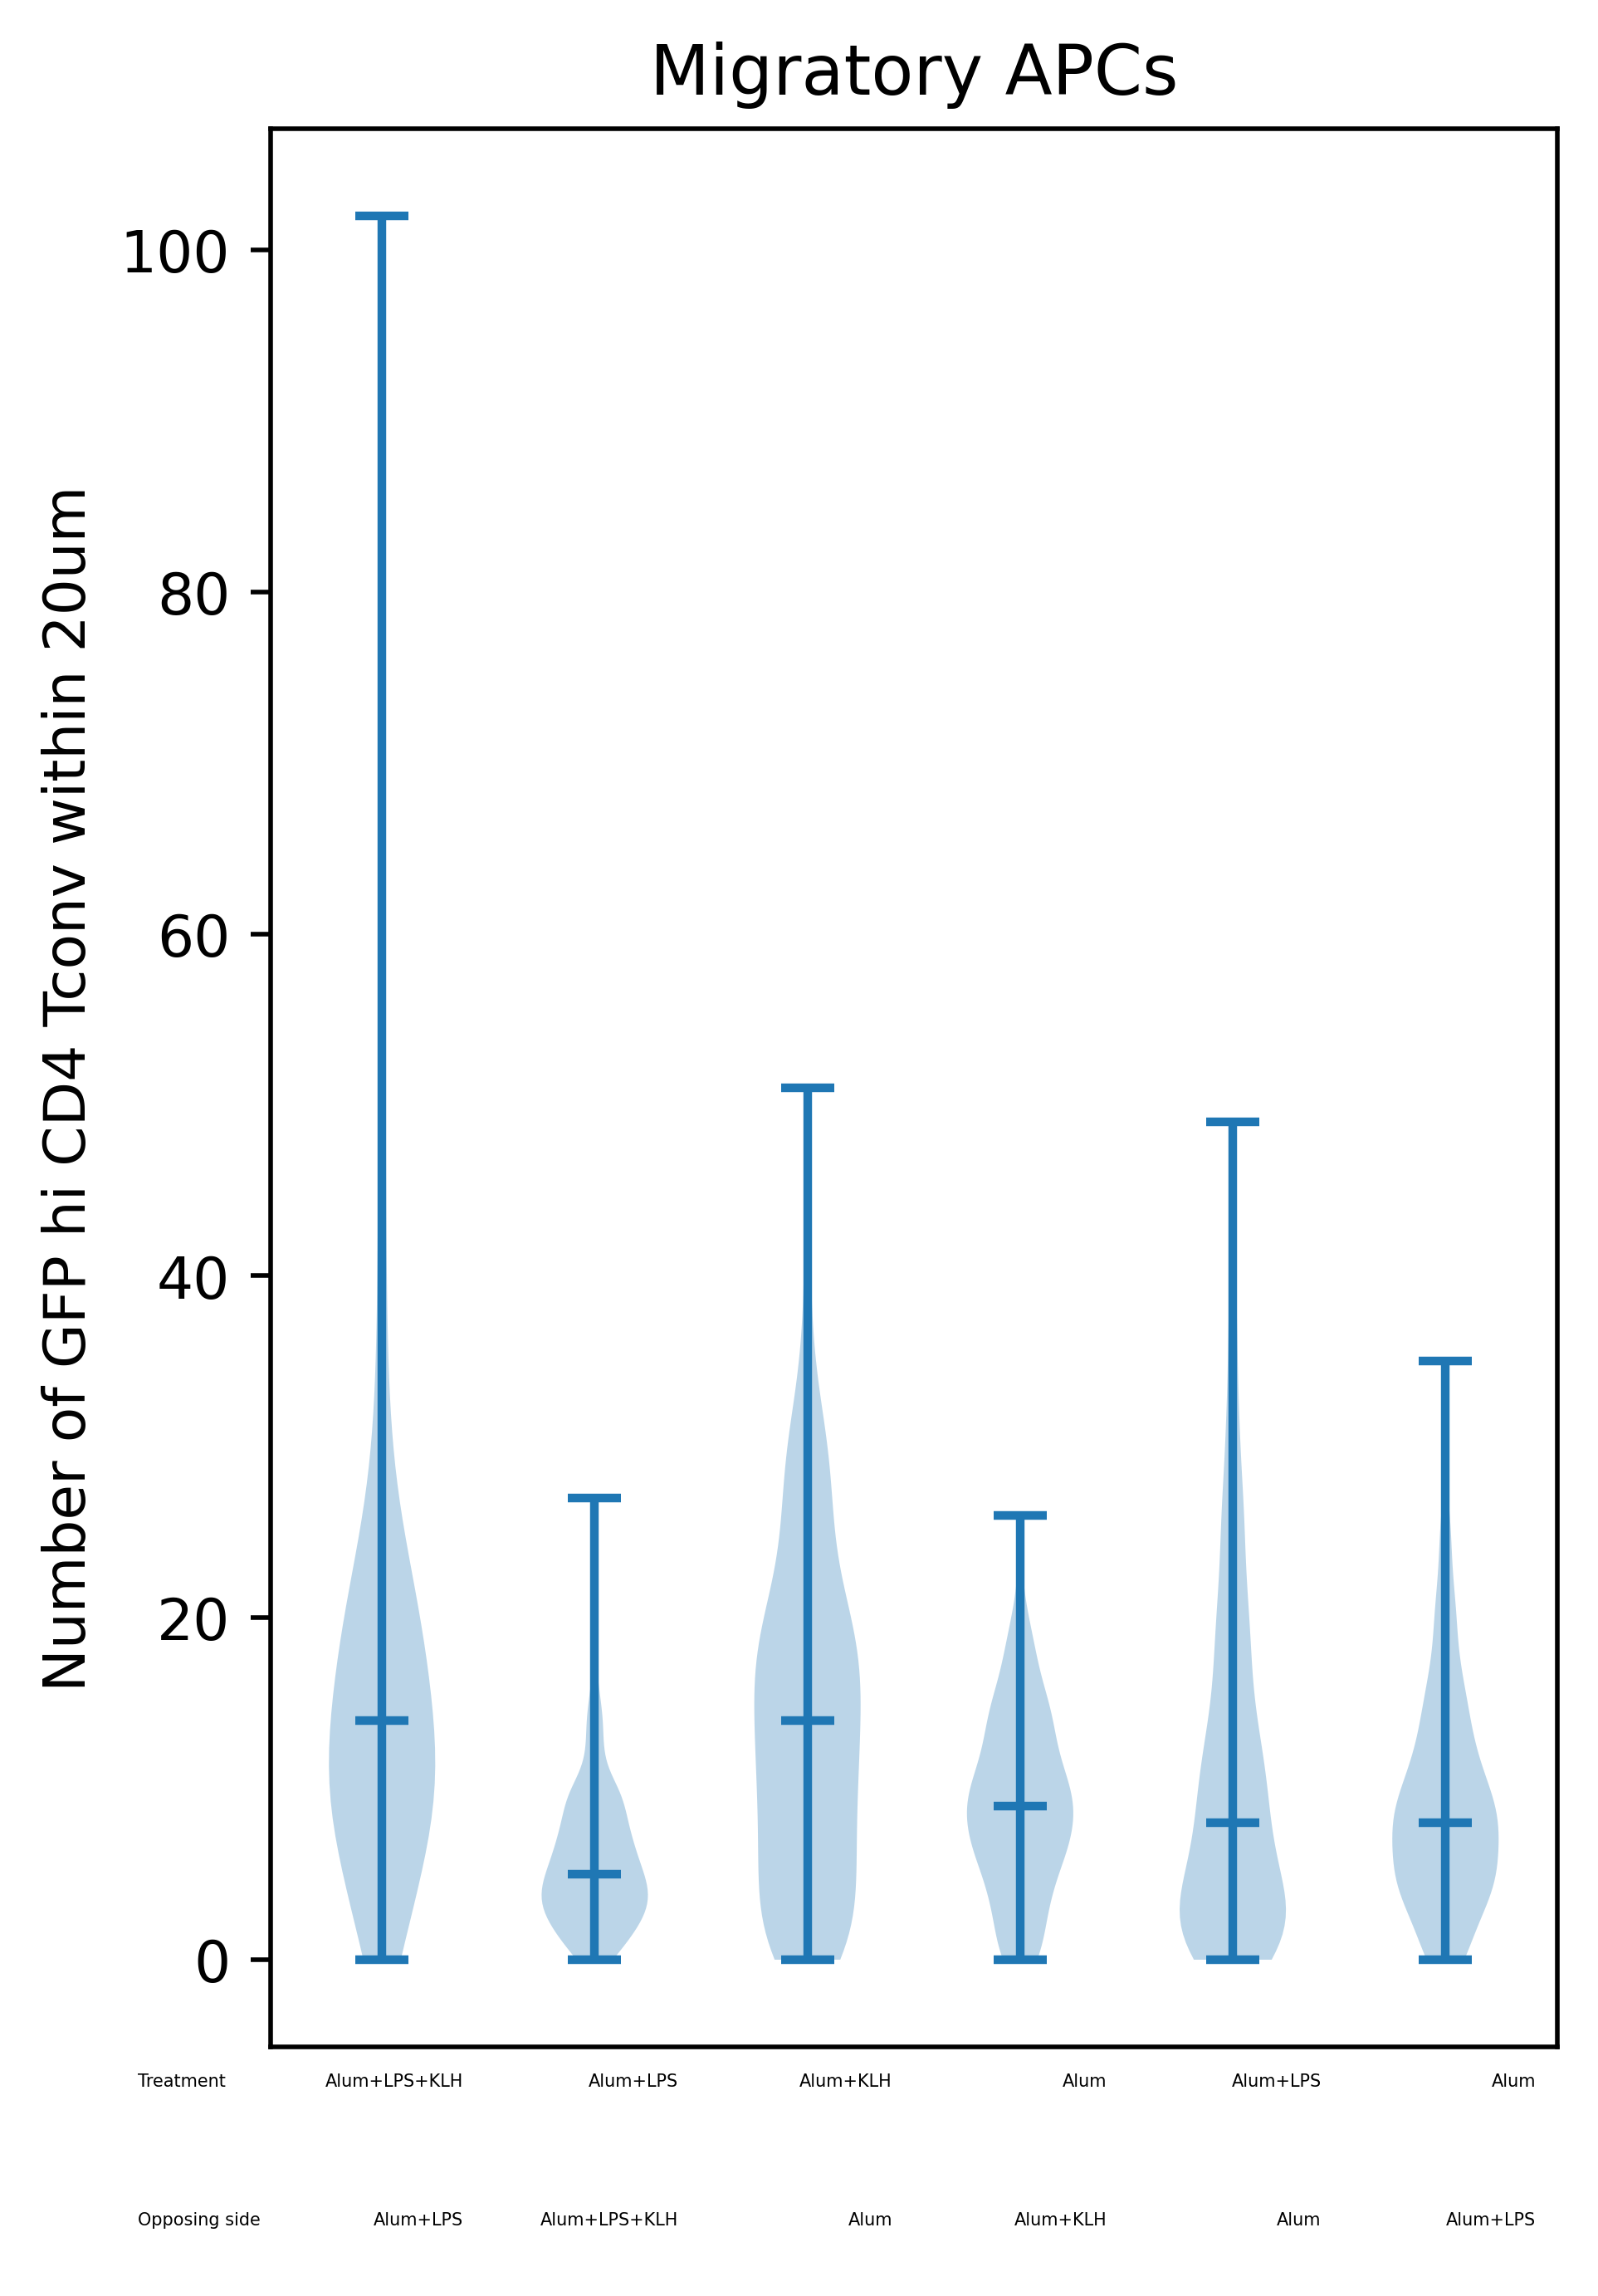

In [19]:
samples=['1L','1R','2L','2R','3L','3R']
plot_data=[np.sum(np.int8(cell_pairs[f'{sample}_Th_mig'][np.array(cells[f'{sample}_Th']['Intensity_Sum_Nur77_GFP']>nur77_thresh),:]<d_max),axis=0) for sample in samples]
fig,ax=plt.subplots(figsize=(4,6))
plt.violinplot(plot_data,showmedians=True)
plt.ylabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
                      rowLabels=['Treatment','','Opposing side'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Migratory APCs')


Text(0, 0.5, 'Number of Tregs within 20um')

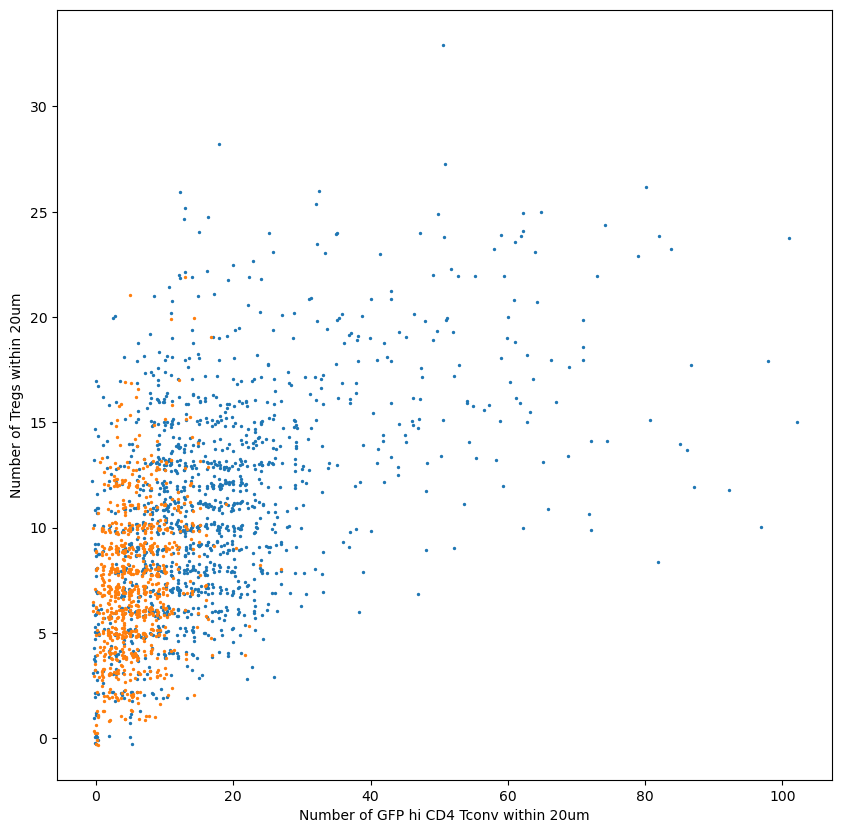

In [170]:
jitter=0.2
for sample in ['1L','1R']:
    plt.scatter(cells[f'{sample}_mig']['proximal_GFP_hi_Th_count']+np.random.normal(0,jitter,size=len(cells[f'{sample}_mig'])),cells[f'{sample}_mig']['proximal_Treg_count']+np.random.normal(0,jitter,size=len(cells[f'{sample}_mig'])),s=2)
plt.xlabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
plt.ylabel(f'Number of Tregs within {d_max}um')

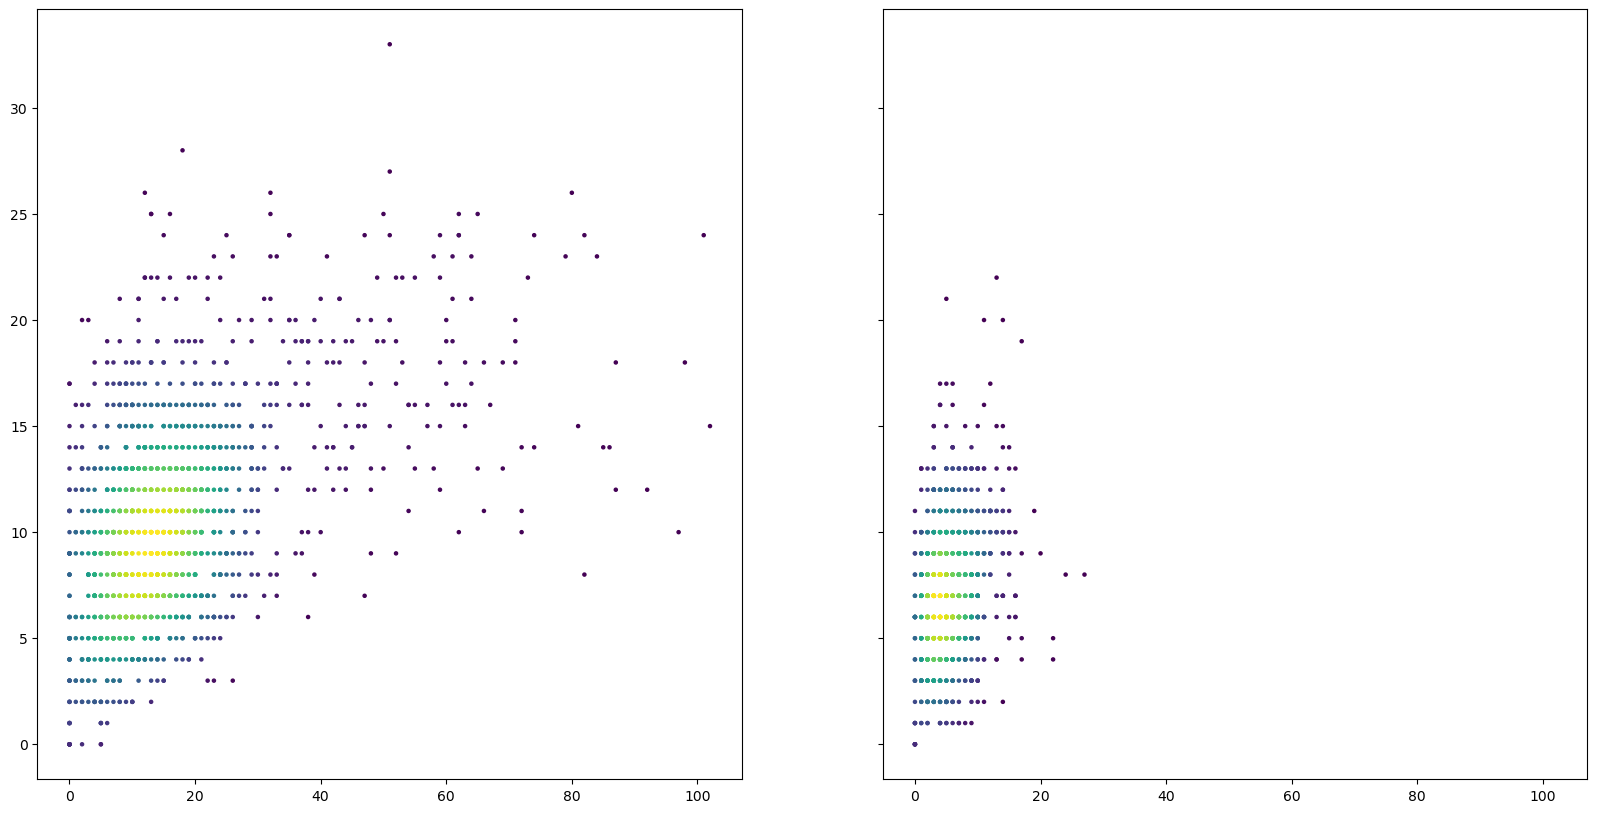

In [191]:
kde_objs={}
for sample in ['1L','1R']:
    kde_objs[sample]=scipy.stats.gaussian_kde([cells[f'{sample}_mig']['proximal_GFP_hi_Th_count'],cells[f'{sample}_mig']['proximal_Treg_count']])
xmin, xmax = -5, 110
ymin, ymax = -2, 35

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(20,10),sharex=True,sharey=True)
for i,sample in enumerate(['1L','1R']):
    # f = np.reshape(kde_objs[sample](positions).T, xx.shape)
    # axs[i].contourf(xx,yy,f,levels=10)
    axs[i].scatter(x=cells[f'{sample}_mig']['proximal_GFP_hi_Th_count'],y=cells[f'{sample}_mig']['proximal_Treg_count'],s=5,c=kde_objs[sample]([cells[f'{sample}_mig']['proximal_GFP_hi_Th_count'],cells[f'{sample}_mig']['proximal_Treg_count']]))

(array([8620,  431,  236,  161,  130,  104,   85,   80,   73,   80],
      dtype=int64), array([1.08539704e-32, 3.47686037e-04, 6.95372075e-04, 1.04305811e-03,
       1.39074415e-03, 1.73843019e-03, 2.08611622e-03, 2.43380226e-03,
       2.78148830e-03, 3.12917434e-03, 3.47686037e-03]))
(array([9582,  127,   81,   40,   41,   33,   30,   24,   21,   21],
      dtype=int64), array([0.        , 0.00126568, 0.00253136, 0.00379704, 0.00506272,
       0.0063284 , 0.00759408, 0.00885977, 0.01012545, 0.01139113,
       0.01265681]))


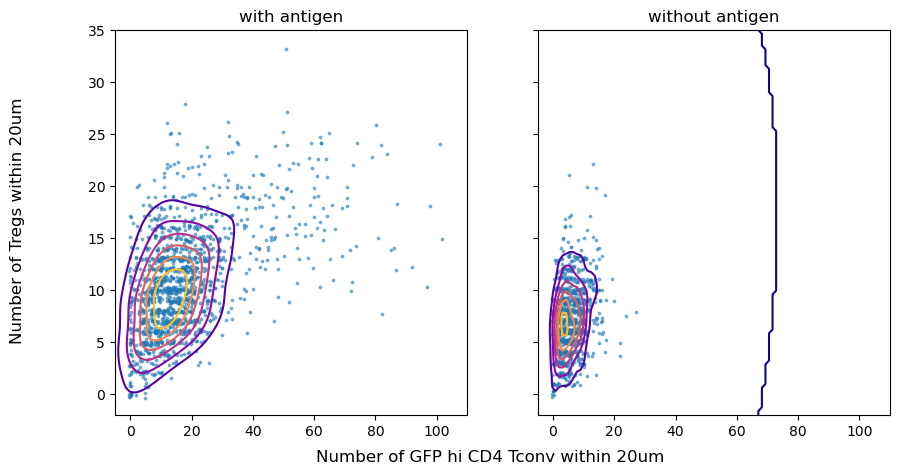

In [27]:
kde_objs={}
jitter=0.2
bw={'1L':0.3,'1R':0.3}
for sample in ['1L','1R']:
    kde_objs[sample]=scipy.stats.gaussian_kde([cells[f'{sample}_mig']['proximal_GFP_hi_Th_count'],cells[f'{sample}_mig']['proximal_Treg_count']],bw_method=bw[sample])
xmin, xmax = -5, 110
ymin, ymax = -2, 35

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,5),sharex=True,sharey=True)
for i,sample in enumerate(['1L','1R']):
    f = np.reshape(kde_objs[sample](positions).T, xx.shape)
    print(np.histogram(f))
    axs[i].contour(xx,yy,f,cmap='plasma')
    # axs[i].scatter(x=cells[f'{sample}_mig']['proximal_GFP_hi_Th_count'],y=cells[f'{sample}_mig']['proximal_Treg_count'],s=5,c=kde_objs[sample]([cells[f'{sample}_mig']['proximal_GFP_hi_Th_count'],cells[f'{sample}_mig']['proximal_Treg_count']]))
    axs[i].scatter(x=cells[f'{sample}_mig']['proximal_GFP_hi_Th_count']+np.random.normal(0,jitter,size=len(cells[f'{sample}_mig'])),y=cells[f'{sample}_mig']['proximal_Treg_count']+np.random.normal(0,jitter,size=len(cells[f'{sample}_mig'])),s=3,alpha=0.5)
axs[0].set_title('with antigen')
axs[1].set_title('without antigen')
fig.supxlabel(f'Number of GFP hi CD4 Tconv within {d_max}um')
fig.supylabel(f'Number of Tregs within {d_max}um')
plt.savefig('cluster_scatter.pdf')

(34900.0, 35100.0)

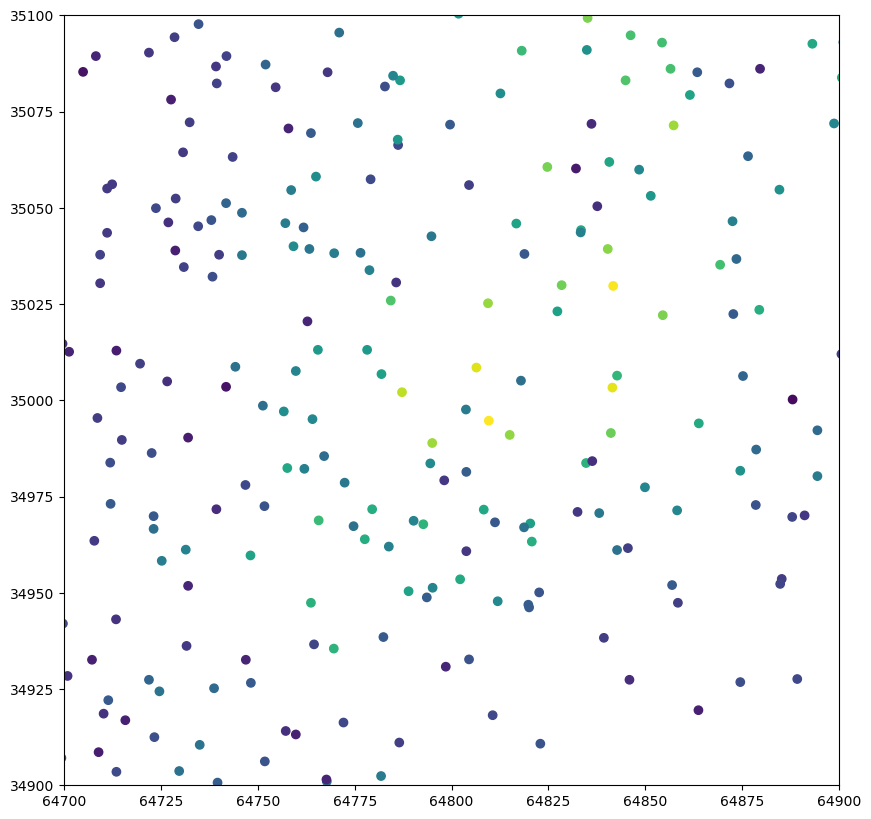

In [92]:
plt.scatter(cells['1L_mig']['Position_X'],cells['1L_mig']['Position_Y'],c=np.sum(np.int8(cell_pairs['1L_Th_mig'][np.array(cells['1L_Th']['Intensity_Sum_Nur77_GFP']>nur77_thresh),:]<d_max),axis=0))
plt.xlim(64700,64900)
plt.ylim(34900,35100)

Text(0.5, 1.0, 'Migratory APCs')

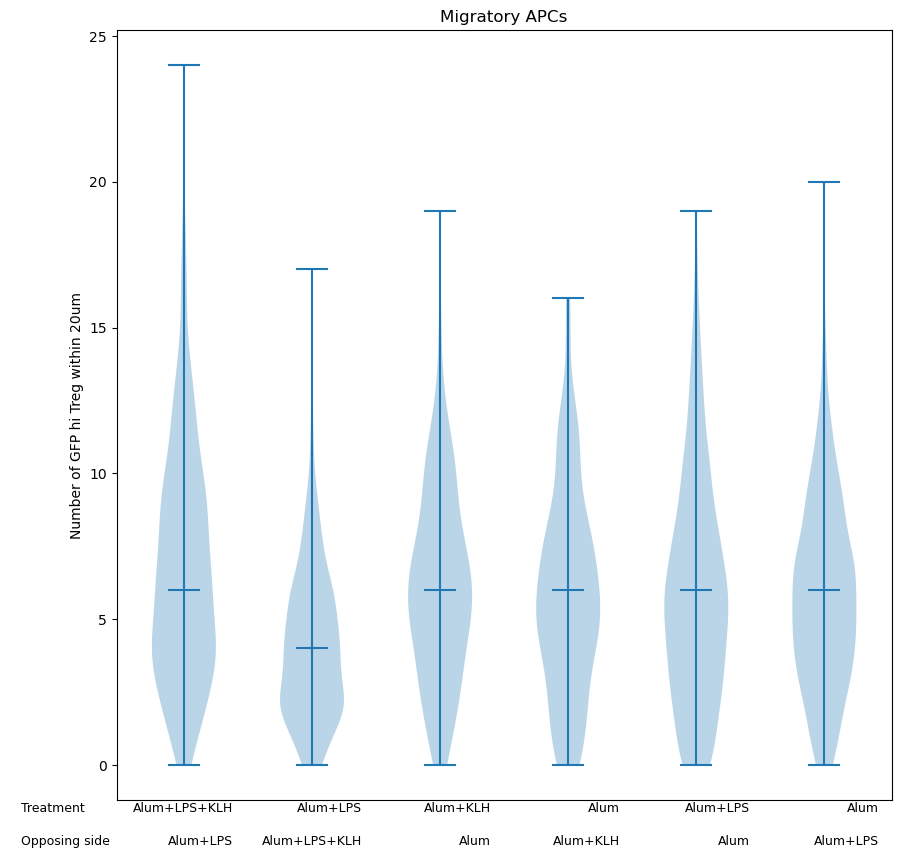

In [93]:
plot_data=[np.sum(np.int8(cell_pairs[f'{sample}_Treg_mig'][np.array(cells[f'{sample}_Treg']['Intensity_Sum_Nur77_GFP']>nur77_thresh),:]<d_max),axis=0) for sample in samples]
plt.violinplot(plot_data,showmedians=True)
plt.ylabel(f'Number of GFP hi Treg within {d_max}um')
plt.table(cellText=[[conditions[sample] for sample in samples],['' for sample in samples],[opposing_side_conditions[sample] for sample in samples]],
                      rowLabels=['Treatment','','Opposing side'],
                      loc='bottom',
                      edges='open')
plt.xticks([])
plt.title('Migratory APCs')

Text(0.5, 1.0, 'Migratory APCs')

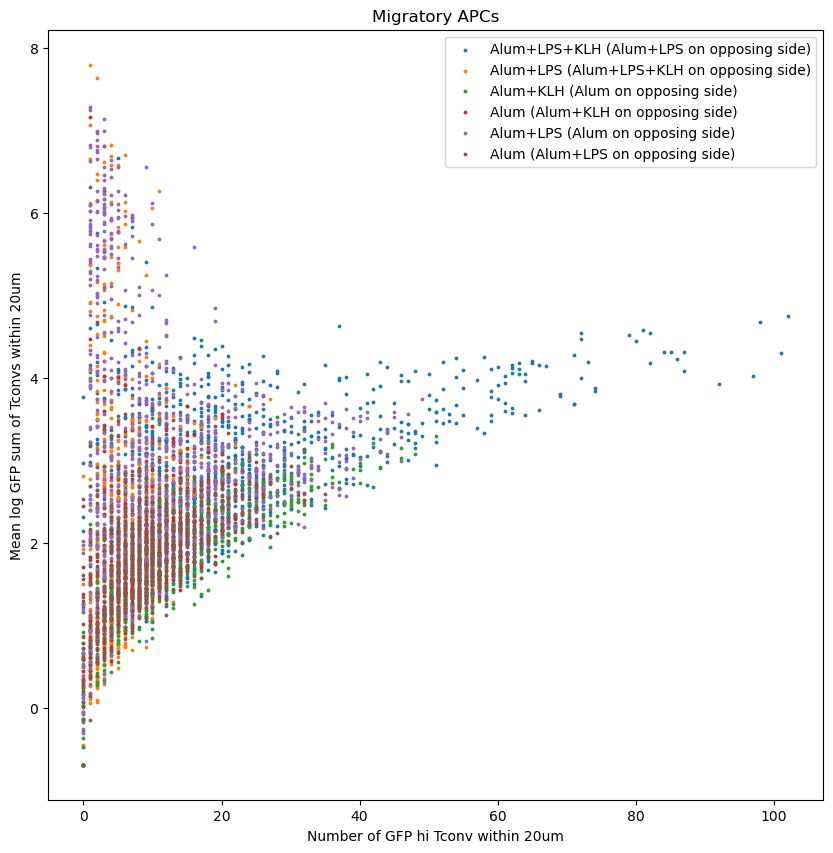

In [30]:
for sample in samples:
    plt.scatter(cells[f'{sample}_mig']['proximal_GFP_hi_Th_count'],cells[f'{sample}_mig']['proximal_Th_GFP_mean'],s=3,label=f'{conditions[sample]} ({opposing_side_conditions[sample]} on opposing side)')

plt.legend()
plt.xlabel('Number of GFP hi Tconv within 20um')
plt.ylabel('Mean log GFP sum of Tconvs within 20um')
plt.title('Migratory APCs')